<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning%20(TF)/Policy%20Based/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import gym
import time
import tensorflow_probability as tfp
from itertools import count

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# Policy Network

This is the fully connected policy network, we will use in the REINFORCE algorithm:

In [ ]:
class PolicyNetwork(tf.keras.Model):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.model = self.get_model()

  def get_model(self):
    inputs = tf.keras.Input(shape=(None, self.input_dim))
    x = tf.keras.layers.Dense(units=128, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(units=self.output_dim)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

  def _format(self, state):
    x = state
    if not isinstance(x, tf.Tensor):
      x = tf.convert_to_tensor(x)
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)

    return x

  def call(self, state):
    x = self._format(state)
    output = self.model(x)

    return output

  def full_pass(self, state):
    logits = self(state)
    # Create a Categorical distribution
    dist = tfp.distributions.Categorical(logits=logits)
    # sample an action from the Categorical distribution
    action = dist.sample()
    # compute the log probabilites of each action
    logpa = dist.log_prob(action)
    logpa = tf.expand_dims(logpa, axis=-1)

    return action.numpy().item(), logpa

  def select_action(self, state):
    # forward pass
    logits = self(state)
    # get a probability distribution
    dist = tfp.distributions.Categorical(logits=logits)
    # sample an action from the probability distribution
    action = dist.sample()

    return action.numpy().item()

  def select_greedy_action(self, state):
    # forward pass
    logits = self(state)
    # return index of action with the highest probability
    return np.argmax(logits)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print summary
env = gym.make("CartPole-v1")
agent = PolicyNetwork(env.observation_space.shape[0],env.action_space.n)
agent.model.summary()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 dense (Dense)               (None, None, 128)         640       
                                                                 
 dense_1 (Dense)             (None, None, 64)          8256      
                                                                 
 dense_2 (Dense)             (None, None, 2)           130       
                                                                 
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


# REINFORCE

The REINFORCE is the simplest policy-gradient algorithm. This algorithm tries to increase the log probability of all actions in a trajectory, proportional to the goodness of the full return (Monte-Carlo return). So, basically, it first collects a full trajectory, calculate the full discounted return and then use that score to weight the log probabilities of every action taken in that trajectory.

The gradient we are trying to estimate is the following one:

$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\biggl[\sum_{t=0}^T G_t(\tau)\nabla_\theta log(\pi_\theta(A_t|S_t))\biggr]$

whereas:



*   $\tau \sim \pi_\theta$ means "sample a trajectory $\tau$"
*   $\sum_{t=0}^T G_t(\tau)$ means "for each timestep t in the trajectory $\tau$, calculate the full return from that step"
*   $log(\pi_\theta(A_t|S_t)$ is the log probability of action $A$ taken at time step t given the state $S$ at time step t

As mentioned above, we use the full return $G_t$ as the score to weight the log probability of the action taken at time step t.

In [ ]:
class REINFORCE():

  def __init__(self,
               env,
               model,
               optimizer,
               gamma,
               seed,
               max_episodes = 10000,
               max_minutes=10,
               goal=475,
               ):

    # set the attributes
    self.env = env
    self.model = model
    self.optimizer = optimizer
    self.gamma = gamma
    self.seed = seed
    self.max_episodes = max_episodes
    self.max_minutes = max_minutes
    self.goal = goal
    self.evaluation_scores = []
    self.mean_eval_scores = []


  def __interact(self, state):
    '''
    Perform the interaction with environment
    '''
    # pass the state through the policy network to
    # sample an action from the probability distribution and
    # also get the log probability of the selected action
    action, logpa = self.model.full_pass(state)
    # take the action in the environment
    next_state, reward, is_terminal, _ = self.env.step(action)
    # store the log probability of the action
    self.logpas.append(logpa)
    # store the experienced reward we get after taking the action
    self.rewards.append(reward)

    return next_state, is_terminal


  def __compute_loss(self):
    '''
    Compute the loss.
    '''

    # compute the number of rewards
    T = len(self.rewards)
    # compute the discounts for each reward
    discounts = np.logspace(0,
                            T,
                            num=T,
                            base=self.gamma,
                            endpoint=False)

    # calculate the full discounted return
    # compute the sum of the discounted returns for all time steps
    # this is the returns for every time step in the current episode
    # from the initial state at time step 0, to one before the terminal T-1
    returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

    # convert the discounts and returns to float tensors
    discounts = tf.convert_to_tensor(discounts, dtype="float32")
    discounts = tf.expand_dims(discounts, axis=1)
    returns = tf.convert_to_tensor(returns, dtype="float32")
    returns = tf.expand_dims(returns, axis=1)

    # concatenate the list of log probabilities
    self.logpas = tf.concat(self.logpas, axis=0)


    # now, compute the loss of the policy network
    # note that we discount the returns; this extra discount assumes
    # that we are trying to optimize the expect discounted return
    # from the initial state, so the returns later in an episode get
    # discounted
    # we also add a minus sign because PyTorch performs gradient descent by default
    # since we want to maximize the performance objective we take the negative mean of
    # the objective to flip it; as a result, the probability of "good" actions will be
    # increased and the probability of "bad" actions will be decreased
    # last but not least, we also account for discounted policy gradients, so we multiply
    # the returns by the discounts
    loss = -tf.reduce_mean(discounts * returns * self.logpas)

    return loss


  def __optimize(self, loss, tape):
    '''
    Optimize the model.
    '''
    # compute the gradients of the loss with respect to the trainable variables
    grads = tape.gradient(loss, self.model.trainable_variables)
    # update the weights
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


  def __evaluate(self, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []
    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False
      # append a 0 to rewards list
      rewards.append(0)
      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = self.model.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = self.model.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # save the reward
        rewards[-1] += reward
        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

  def train(self):
    '''
    Train the agent.
    '''
    # get the starting time of the training phase
    training_start = time.time()
    # for each episode do the following
    for episode in range(1, self.max_episodes + 1):

      # get the initial state
      state = self.env.reset(seed=self.seed)
      # is_terminal flag to indicate whether an episode is finished
      is_terminal = False
      # list to hold the log probabilities of the actions
      self.logpas = []
      # list to hold the rewards
      self.rewards = []

      with tf.GradientTape() as tape:
        # we first collect a full trajectory
        for timestep in count():
          # interact with the environment
          state, is_terminal = self.__interact(state)
          # finish current episode if a terminal state is reached
          if is_terminal:
            break

        # compute the loss
        loss = self.__compute_loss()

      # update the weights
      self.__optimize(loss, tape)
      # compute the evaluation score
      evaluation_score = self.__evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)
      # compute the mean evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      # append mean evaluation score (will be used later for visualization)
      self.mean_eval_scores.append(mean_100_eval_score)
      print(f"Current mean evaluation score {mean_100_eval_score}") # printing for debugging purposes

      # calculate the elapsed wallclock time
      wallclock_elapsed = time.time() - training_start

      # flag indicating whether max minutes are reached or not
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      # flag indicating whether max episodes are reached or not
      reached_max_episodes = episode >= self.max_episodes
      # flag indicating whether the mean reward goal is reached
      reached_goal_mean_reward = mean_100_eval_score >= self.goal

      # flag that decides whether is over or not
      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    # compute final evaluation score
    final_evaluation_score = self.__evaluate(episodes=100)
    print(f"Final evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

# Train

In [ ]:
# define the our discount factor
gamma = 1.00
# define max minutes
max_minutes = 20
# define nr. of max episodes
max_episodes = 10000
# define mean reward value
goal = 475
# define the learning rate
lr = 0.0005

current_best_agent = None
current_best_eval_score = float('-inf')
seeds = (12, 34, 56, 78, 90)

In [ ]:
# we let five REINFORCE agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in seeds:
  print("Starting a new REINFORCE agent.")
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  # obtain the number of variables used in each state and the number of actions
  state_space = env.observation_space.shape[0]
  action_space = env.action_space.n
  # build the online network
  policy_model = PolicyNetwork(state_space, action_space)
  # create an instance of the RMSprop optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  # create the REINFORCE agent
  reinforce_agent = REINFORCE(env,
                              policy_model,
                              optimizer,
                              gamma,
                              seed,
                              max_episodes,
                              max_minutes,
                              goal
                              )

  # let the REINFORCE agent train
  final_evaluation_score = reinforce_agent.train()

  if final_evaluation_score > current_best_eval_score:
    current_best_eval_score = final_evaluation_score
    current_best_agent = reinforce_agent

Starting a new REINFORCE agent.
Current mean evaluation score 25.0
Current mean evaluation score 24.0
Current mean evaluation score 23.666666666666668
Current mean evaluation score 24.0
Current mean evaluation score 24.8
Current mean evaluation score 25.333333333333332
Current mean evaluation score 26.714285714285715
Current mean evaluation score 27.125
Current mean evaluation score 27.444444444444443
Current mean evaluation score 27.7
Current mean evaluation score 27.90909090909091
Current mean evaluation score 28.083333333333332
Current mean evaluation score 28.23076923076923
Current mean evaluation score 28.357142857142858
Current mean evaluation score 28.466666666666665
Current mean evaluation score 28.5625
Current mean evaluation score 28.647058823529413
Current mean evaluation score 28.11111111111111
Current mean evaluation score 27.526315789473685
Current mean evaluation score 26.85
Current mean evaluation score 26.19047619047619
Current mean evaluation score 25.545454545454547


# Saved the model

In [ ]:
current_best_agent.model.save_weights("/content/drive/MyDrive/Tensorflow/REINFORCE/REINFORCE.ckpt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualization

Let's plot the mean of rewards our best agent has collected during the training process:

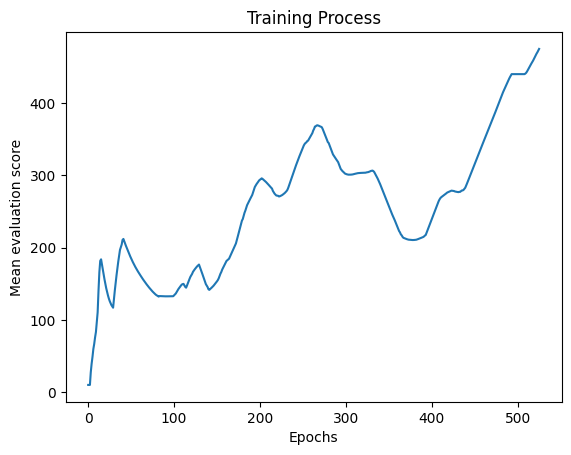

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reinforce_agent.mean_eval_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

# Let our REINFORCE agent play CartPole

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(0, episodes):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # select an action from the probability distribution
      action = reinforce_agent.model.select_greedy_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Tensorflow/REINFORCE/Gif/', 'REINFORCE_agent.gif'), frames, duration=20)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


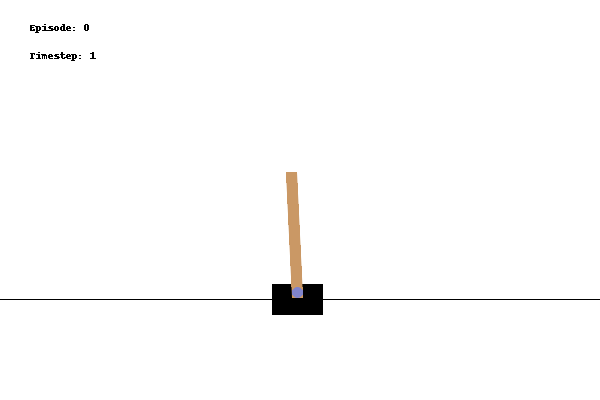

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Tensorflow/REINFORCE/Gif/REINFORCE_agent.gif','rb').read())